In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error


train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(train.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


In [0]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [0]:
print(train.shape[1])

81


In [0]:
print("歪度: %f" % train['SalePrice'].skew())
print("尖度: %f" % train['SalePrice'].kurt())

歪度: 1.882876
尖度: 6.536282


In [0]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


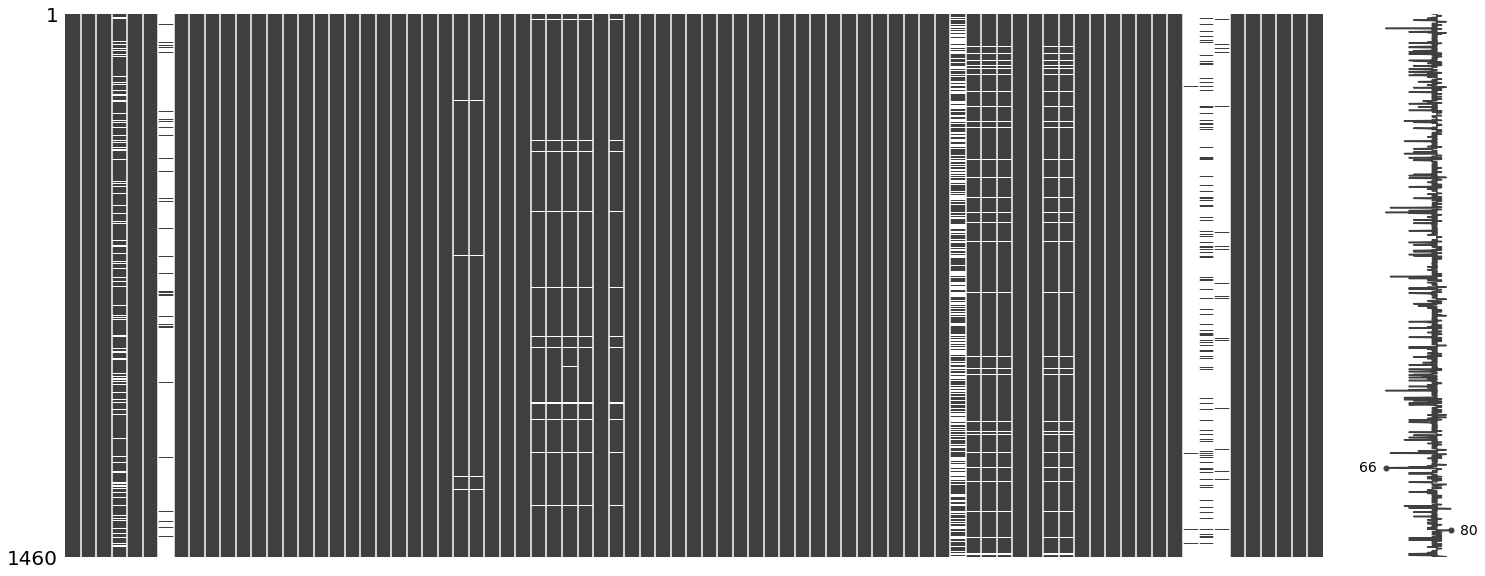

In [0]:
import missingno as msno
msno.matrix(df=train)

In [0]:
#pd.set_option('display.max_rows', None)
train.isnull().sum()

In [0]:
test.isnull().sum()

In [0]:
# dealing with missing data
all_data = pd.concat([train,test],axis=0,sort=True)
all_data['LotFrontage'] =all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [0]:
na_col_list = all_data.isnull().sum()[all_data.isnull().sum()>0].index.tolist()
float_list = all_data[na_col_list].dtypes[all_data[na_col_list].dtypes == "float64"].index.tolist()

#欠損値が存在するかつobject型のリストを作成
obj_list = all_data[na_col_list].dtypes[all_data[na_col_list].dtypes == "object"].index.tolist()

#float型の場合は欠損値を0で置換
all_data[float_list] = all_data[float_list].fillna(0)

#object型の場合は欠損値を"None"で置換
all_data[obj_list] = all_data[obj_list].fillna("None")

In [0]:
all_data[float_list].isnull().sum()

BsmtFinSF1      0
BsmtFinSF2      0
BsmtFullBath    0
BsmtHalfBath    0
BsmtUnfSF       0
GarageArea      0
GarageCars      0
GarageYrBlt     0
MasVnrArea      0
TotalBsmtSF     0
dtype: int64

In [0]:
print(len(all_data['SalePrice']))

2919


In [0]:
train = all_data.iloc[:len(all_data['SalePrice']),:]
test = all_data.iloc[len(all_data['SalePrice']):,:]

In [0]:
#X と　Y　に分ける
train_ID = train['Id']
test_ID = test['Id']

# split data for training
y_train = train['Id'],train['SalePrice']
X_train = train.drop(['Id','SalePrice'], axis=1)
X_test = test.drop('Id', axis=1)

Text(0, 0.5, 'SalePrice')

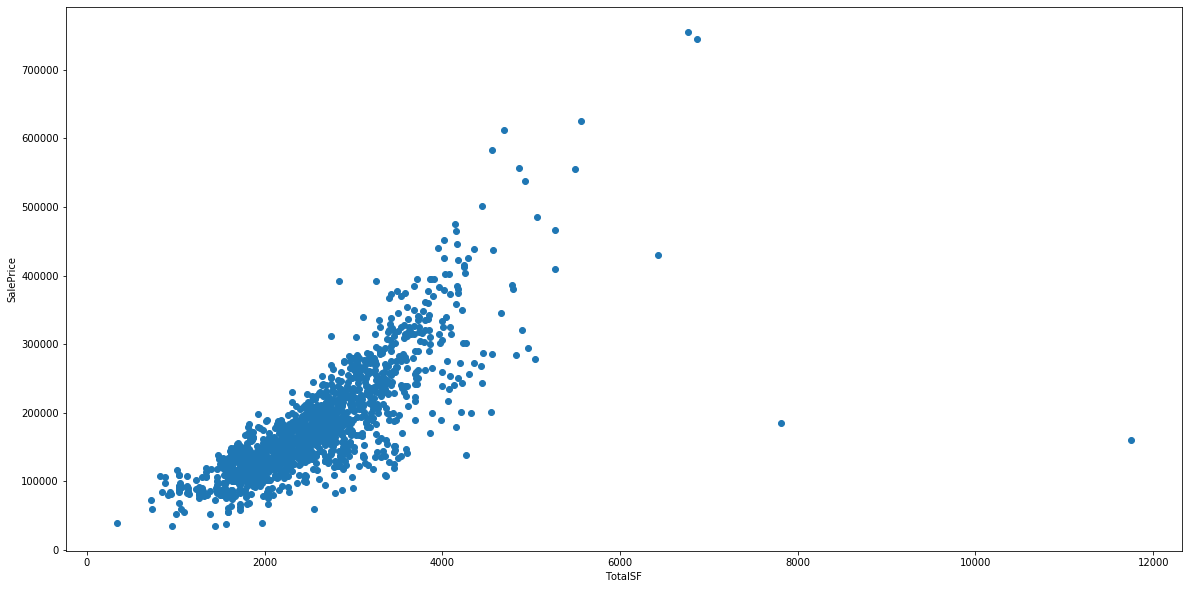

In [0]:
X_mat = pd.concat([X_train,X_test],axis=0,sort=True)
Xmat["TotalSF"] = Xmat["TotalBsmtSF"] + Xmat["1stFlrSF"] + Xmat["2ndFlrSF"]

X_train = Xmat.iloc[:train.shape[0],:]
X_test = Xmat.iloc[train.shape[0]:,:]

plt.figure(figsize=(20, 10))
Xmat = pd.concat([X_train, X_test])
plt.scatter(X_train["TotalSF"],y_train)
plt.xlabel("TotalSF")
plt.ylabel("SalePrice")

In [0]:
#trainを作る
train= X_train
train['SalePrice'] = y_train

Text(0, 0.5, 'SalePrice')

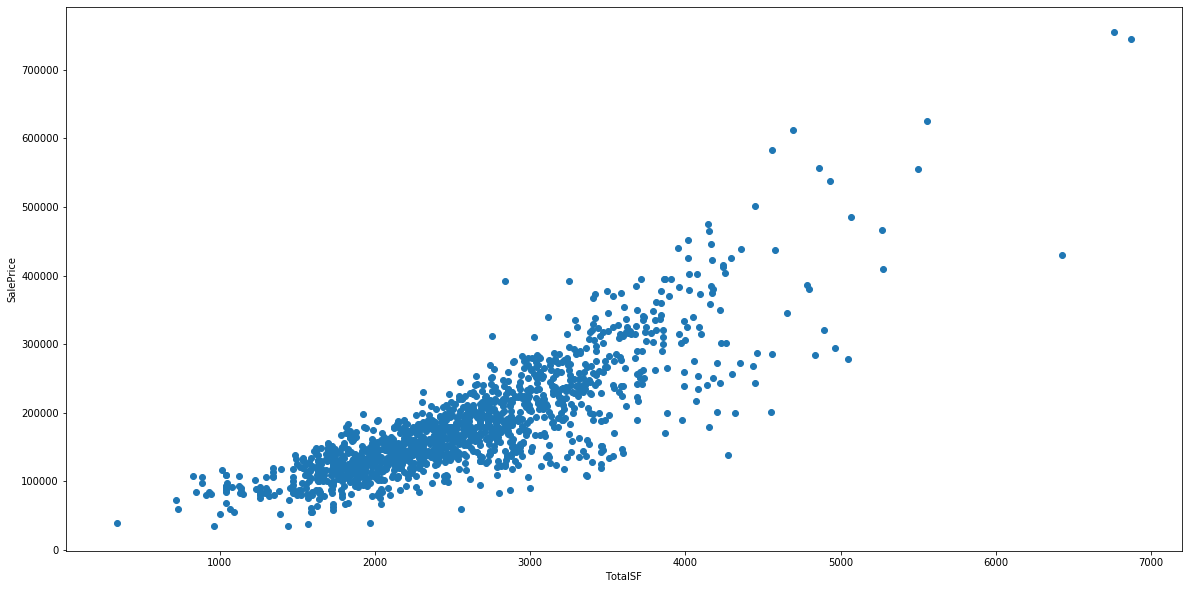

In [0]:
train = train.drop(train[(train['TotalSF']>7500) & (train['SalePrice']<300000)].index)
plt.figure(figsize=(20,10))
plt.scatter(train["TotalSF"], train["SalePrice"])
plt.xlabel("TotalSF")
plt.ylabel("SalePrice")

In [0]:
#trainを崩す
y_train = train['SalePrice']
X_train = train.drop(['SalePrice'], axis=1)

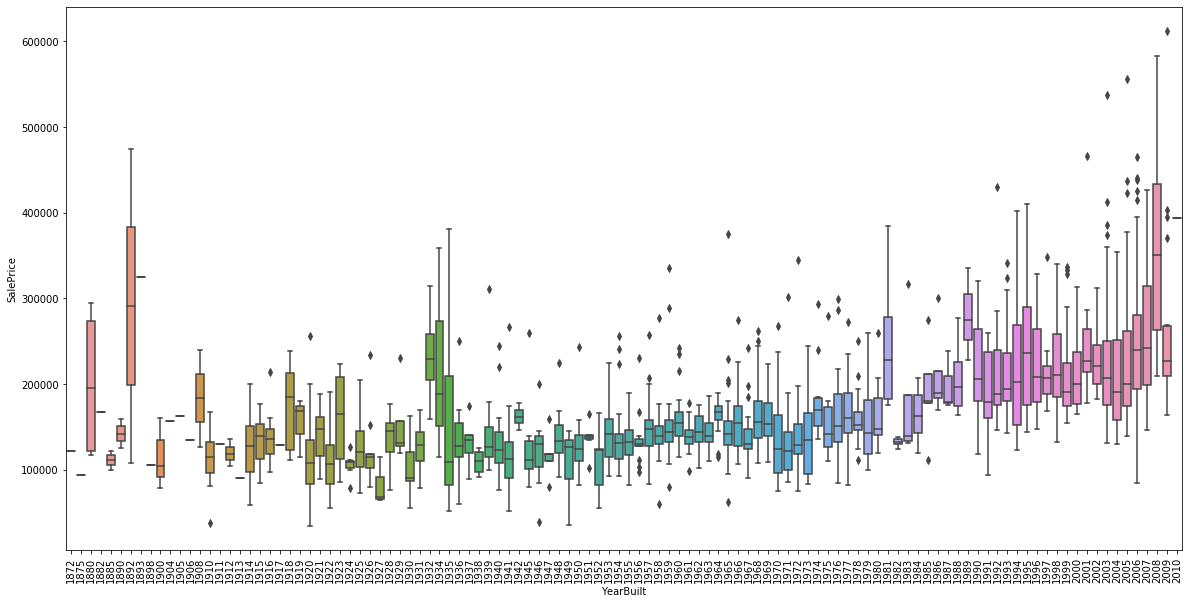

In [0]:
train= X_train
train['SalePrice'] = y_train
data = pd.concat([train["YearBuilt"],train["SalePrice"]],axis=1)
train = train.drop(train[(train['YearBuilt']<2000) & (train['SalePrice']>600000)].index)

#グラフを描画する
data = pd.concat([train["YearBuilt"],train["SalePrice"]],axis=1)

plt.figure(figsize=(20, 10))
plt.xticks(rotation='90')
sns.boxplot(x="YearBuilt",y="SalePrice",data=data)

Text(0, 0.5, 'SalePrice')

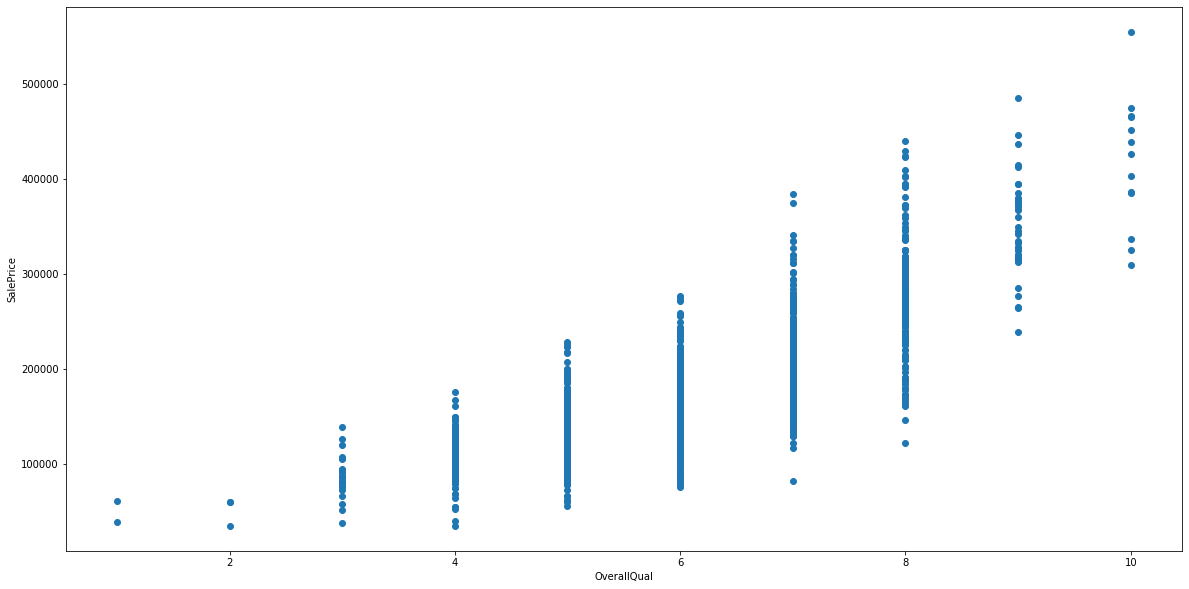

In [0]:
train = train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index)
train = train.drop(train[(train['OverallQual']<10) & (train['SalePrice']>500000)].index)

#グラフを描画する
plt.figure(figsize=(20, 10))
plt.scatter(train["OverallQual"],train["SalePrice"])
plt.xlabel("OverallQual")
plt.ylabel("SalePrice")

In [0]:
train= X_train
train['SalePrice'] = y_train

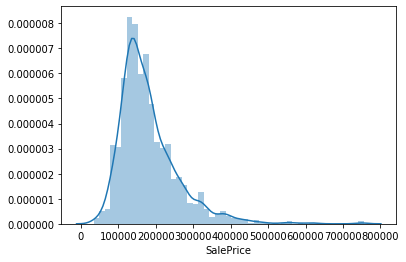

In [0]:

ax = sns.distplot(y_train)
plt.show()

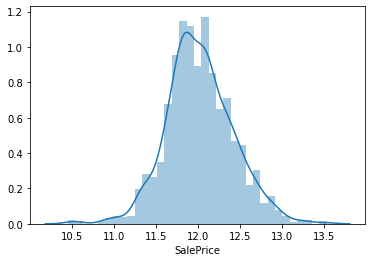

In [0]:
y_train = np.log(y_train)

ax = sns.distplot(y_train)
plt.show()

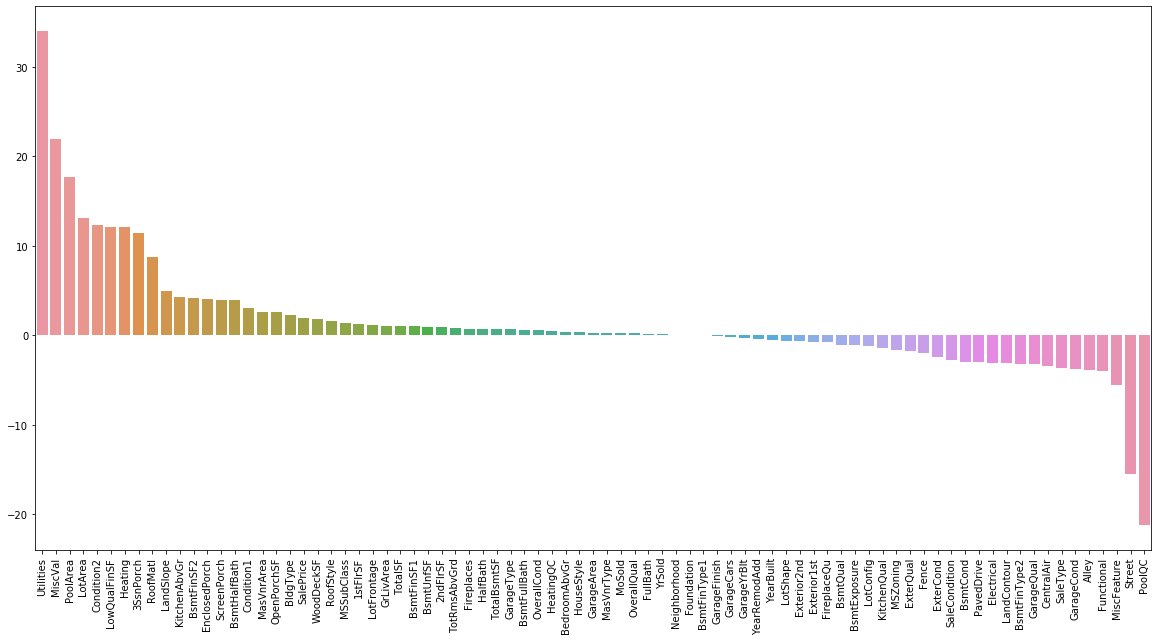

In [0]:
all_data = pd.concat([X_train,X_test],axis=0,sort=True)
num_feats = all_data.dtypes[all_data.dtypes != "object" ].index
skewed_feats = all_data[num_feats].apply(lambda x: x.skew()).sort_values(ascending = False)

plt.figure(figsize=(20,10))
plt.xticks(rotation="90")
sns.barplot(x=skewed_feats.index, y=skewed_feats)

In [0]:
from sklearn.preprocessing import PowerTransformer
skewed_feats_over = skewed_feats[abs(skewed_feats) > 0.5].index
pt = PowerTransformer()
pt.fit(X_train[skewed_feats_over])
X_train[skewed_feats_over] = pt.transform(X_train[skewed_feats_over])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [0]:
#特徴量に1部屋あたりの面積を追加
all_data["FeetPerRoom"] =  all_data["TotalSF"]/all_data["TotRmsAbvGrd"]

#建築した年とリフォームした年の合計
all_data['YearBuiltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

#バスルームの合計面積
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

#縁側の合計面積
all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])

#プールの有無
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

#2階の有無
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

#ガレージの有無
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

#地下室の有無
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

#暖炉の有無
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [0]:
# カテゴリ変数　数値化
from sklearn.preprocessing import LabelEncoder

for i in range(train.shape[1]):
  if train.iloc[:,i].dtypes == object:
    lbl = LabelEncoder()
    lbl.fit(list(train.iloc[:,i].values) + list(test.iloc[:,i].values))
    train.iloc[:,i] = lbl.transform(list(train.iloc[:,i].values))
    test.iloc[:,i] = lbl.transform(list(test.iloc[:,i].values))

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [0]:
y_train = all_data['SalePrice']
X_train = all_data.drop(['SalePrice'], axis=1)

In [0]:
#pd.set_option('display.max_rows', None)
X_train.isnull().sum()

In [0]:
rf = RandomForestRegressor(n_estimators=60,max_features="auto")
rf.fit(X_train, y_train)
print("どれだけ大事か")

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11,9))
sns.barplot(x=rf.feature_importances_[ranking], y=X_train.columns.values[ranking], orient="h")
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [0]:
#paramG = {'n_estimators':[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}

In [0]:
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import r2_score
#forest_grid = GridSearchCV(estimator=RandomForestRegressor(random_state=0),
#                 param_grid = paramG,   
#                 scoring="r2", 
#                 cv = 4,
#                 n_jobs = -1)
#forest_grid.fit(tr_x, tr_y)
#print(forest_grid.best_estimator_.n_estimators)

In [0]:
X_train = X_train.iloc[:,ranking[:30]]
X_test = X_test.iloc[:,ranking[:30]]

X_train["Interaction"] = X_train["TotalSF"]*X_train["OverallQual"]
X_test["Interaction"] = X_test["TotalSF"]*X_test["OverallQual"]

#標準化
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

In [0]:
#KFold
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(X_train))[0]
 
tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

In [0]:
# XGBoost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

print("Parameter optimization")
xgb_model = xgb.XGBRegressor()
reg_xgb = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, 
                    #別のもやってみたいね
                    verbose=1)
reg_xgb.fit(X_train, y_train)

In [0]:
va_pred = reg_xgb.predict(va_x)
score = np.sqrt(mean_squared_error(va_y, va_pred))
print(score)

0.09045013950015833


In [0]:
def create_model(optimizer='adam'):
  model = Sequential()
  model.add(Dense(X_train.shape[1], 
                  input_dim=X_train.shape[1],
                  kernel_initializer="normal",
                  activation="relu"))
  model.add(Dense(16, 
                  kernel_initializer="normal",
                  activation="relu"))
  model.add(Dense(1,
                  kernel_initializer="normal"))
  model.compile(loss="mean_squared_error",
                optimizer = "adam",)
  return model

model = Sequential()
model.add(Dense(X_train.shape[1], 
                  input_dim=X_train.shape[1],
                  kernel_initializer="normal",
                  activation="relu"))
model.add(Dense(16, 
                  kernel_initializer="normal",
                  activation="relu"))
model.add(Dense(1,
                  kernel_initializer="normal"))
model.compile(loss="mean_squared_error",
                optimizer = "adam",)

batch_size = 120
epochs = 10
history = model.fit(tr_x,tr_y,
                    batch_size = batch_size,
                    epochs=epochs,
                    validation_data=(va_x, va_y))

In [0]:
va_pred = model.predict(va_x)
score = np.sqrt(mean_squared_error(va_y, va_pred))
print(score)

7.587136259010815


In [0]:
model = KerasRegressor(build_fn=create_model,
                        verbose=0)
optimizer=["SGD", "Adam"]
batch_size = [10,30,50]
epochs = [10,50,100]
param_grid = dict(optimizer=optimizer,
                  batch_size=batch_size,
                  epochs=epochs)
reg_dl = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
reg_dl.fit(tr_x, tr_y)
va_pred = reg_dl.predict(va_x)
score = np.sqrt(mean_squared_error(va_y, va_pred))
print(score)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.19866852681600602


In [0]:
from sklearn.svm import SVR

gridsearch = GridSearchCV(SVR(kernel='rbf',gamma=0.1),
                          cv=4, 
                          param_grid = {"C":[1e0, 1e1, 1e2, 1e3],
                          "epsilon":[1e0, 1e1, 1e2, 1e3],
                          "gamma":np.logspace(-2, 2, 5)}, )

In [0]:
gridsearch.fit(tr_x, tr_y)
va_pred = gridsearch.predict(va_x)
score = np.sqrt(mean_squared_error(va_y, va_pred))
print(score)

0.3173707927124766


In [0]:
X_train2 = pd.DataFrame({
    "XGB":reg_xgb.predict(X_train),
    "DL" : reg_dl.predict(X_train).ravel(),
    "SVR" : gridsearch.predict(X_train),
    })
X_train2.head()

,XGB,DL,SVR
0,12.230800,12.063013,11.923433
1,12.130808,12.250626,11.902710
2,12.258769,12.117012,11.956409
3,11.920363,11.935307,11.865339
4,12.585774,12.463625,12.086998


In [0]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train2, y_train)

X_test2 = pd.DataFrame({
    "XGB":reg_xgb.predict(X_test),
    "DL" : reg_dl.predict(X_test).ravel(),
    "SVR" : gridsearch.predict(X_test),
    })

y_pred = np.exp(reg.predict(X_test2))

submission2 = pd.DataFrame({
    "Id": test_ID,
    "SalePrice":y_pred
})
submission2.to_csv("submission2.csv", index=False)

In [0]:
y_pred = np.exp(reg_xgb.predict(X_test))

submission2 = pd.DataFrame({
    "Id": test_ID,
    "SalePrice":y_pred
})
submission2.to_csv("submission_xgb.csv", index=False)